# Pairwise

For motif calls for 2 motifs and insertion bigwigs, compute accessibility as a function of distance between instances of the two motifs.

Summary: Don't seem to recap trends seen from in-silico mariginalization.

In [1]:
import numpy as np 
import pandas as pd
import intervaltree
import pyBigWig

from random import sample
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

In [4]:
motif1 = pd.read_csv("./scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.1000.OCTSOX.top_oneperc_imp.bed", 
                     names=["chr", "start", "end", "strand", "score", "seq"],
                     sep='\t') 

motif2 = pd.read_csv("./scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.1000.KLF.top_oneperc_imp.bed", 
                     names=["chr", "start", "end", "strand", "score", "seq"],
                     sep='\t')

motif1.head()

,chr,start,end,strand,score,seq
0,chr1,840140,840154,-,7.240431,ATATACTTGACAATA
1,chr1,1191779,1191793,+,6.785524,TATAGATATTCAGTT
2,chr1,1638777,1638791,+,6.882483,CTTTATTATGAAACA
3,chr1,1801922,1801936,-,7.472690,ATTAGTATCAGAAAA
4,chr1,1828464,1828478,-,6.104234,ATGTACACAACAATC


In [5]:
print(motif1.shape)
print(motif2.shape)

(145616, 6)
(169852, 6)


In [6]:
# assign peak set idx to motifs
PEAK_SET_BASE = "../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx{}.bed"
peak_set_intervals = defaultdict(intervaltree.IntervalTree)

PEAK_SET_SELECT = [8,10,11,13]
for peak_set_idx in PEAK_SET_SELECT:
    with open(PEAK_SET_BASE.format(peak_set_idx)) as f:
        for i,x in enumerate(f):
            x = x.strip().split('\t')
            peak_set_intervals[x[0]][int(x[1]):int(x[2])] = peak_set_idx

In [8]:
CIDS = [4,2,1]
read_bws = [pyBigWig.open("/users/surag/oak/projects/scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx{:d}.bw".format(x)) \
                         for x in CIDS]

In [9]:
# [x.close() for x in read_bws]

In [10]:
all_chrs = set(motif1["chr"]).union(set(motif2["chr"]))

In [11]:
def populate_intervals(motif_df, chrs):
    its = {x:intervaltree.IntervalTree() for x in all_chrs}
    for i,x in motif_df.iterrows():
        its[x["chr"]][x["start"]:x["end"]] = x["strand"]
    
    return its

In [12]:
motif1_its = populate_intervals(motif1, all_chrs)
motif2_its = populate_intervals(motif2, all_chrs)

In [13]:
def switch_strand(x):
    return '+' if x=="-" else "-"

In [14]:
spacing_x_counts = [[] for _ in read_bws]
MAX_SPACING = 100 # looking this value from either side for motif2
READ_HALF_REGION = 500 # count reads from 2x this value

for chrm in motif1_its:
    for m1_it in motif1_its[chrm]:
#         if len(motif1_its[chrm][m1_it.begin-MAX_SPACING:m1_it.begin+MAX_SPACING])!=1:
#             continue

        m2_ngbs =  motif2_its[chrm][m1_it.begin-MAX_SPACING:m1_it.begin+MAX_SPACING]

        if m2_ngbs and len(m2_ngbs)==1:
            read_ct = [f.values(chrm, 
                                m1_it.begin-READ_HALF_REGION,
                                m1_it.begin+READ_HALF_REGION) \
                       for f in read_bws]
            read_ct = [np.log(1+np.sum(np.nan_to_num(x))) for x in read_ct]

            for m2_it in m2_ngbs:
                # trying to make it identical to in-silico expt
                # where m1 is always at the center 
                # and m2 moves to the right of it
                if m2_it.begin >= m1_it.begin:
                    strands = (m1_it.data, m2_it.data)
                    dist = m2_it.begin - m1_it.end
                else:
                    strands = (switch_strand(m1_it.data), switch_strand(m2_it.data))
                    dist = m1_it.begin - m2_it.end
                
                for i in range(len(read_bws)):
                    spacing_x_counts[i].append((dist,strands,read_ct[i],chrm, m1_it, m2_it))

In [15]:
len(spacing_x_counts[0])

51739

In [16]:
sample(spacing_x_counts[0], 5)

[(83,
  ('-', '-'),
  3.828641396489095,
  'chr4',
  Interval(98580739, 98580753, '+'),
  Interval(98580642, 98580656, '+')),
 (94,
  ('+', '+'),
  3.6635616461296463,
  'chr18',
  Interval(40094266, 40094280, '-'),
  Interval(40094158, 40094172, '-')),
 (82,
  ('-', '+'),
  3.4011973816621555,
  'chr12',
  Interval(76429584, 76429598, '-'),
  Interval(76429680, 76429694, '+')),
 (26,
  ('-', '+'),
  3.6375861597263857,
  'chr14',
  Interval(48261609, 48261623, '-'),
  Interval(48261649, 48261663, '+')),
 (46,
  ('+', '-'),
  4.553876891600541,
  'chr6',
  Interval(53195731, 53195745, '+'),
  Interval(53195791, 53195805, '-'))]

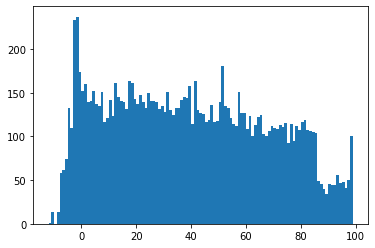

In [17]:
plt.hist([x[0] for x in spacing_x_counts[1] if x[1]==("+","+")], bins=111)
plt.show()
# plt.xlim(70,100)

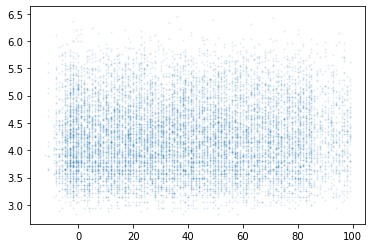

In [18]:
subset = [x for x in spacing_x_counts[0] if x[1]==("+","+")]
plt.scatter([x[0] for x in subset], [x[2] for x in subset], s=1, alpha=0.1)

In [19]:
np.median([x[2] for x in subset])

4.204692619390966

In [20]:
np.median([x[2] for x in subset if  x[0]>80])

4.276666119016055

In [21]:
np.median([x[2] for x in subset if  x[0]<20])

4.174387269895637

In [38]:
from scipy.stats import spearmanr, pearsonr

In [23]:
spearmanr([x[0] for x in subset], [x[2] for x in subset])

SpearmanrResult(correlation=0.025333485960636986, pvalue=0.004088390036442269)

In [24]:
peak_set_intervals['chr1'][48201]

{Interval(48200, 48959, 10)}

In [25]:
Counter([x[1] for x in spacing_x_counts[0] if peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==8])

Counter({('-', '+'): 3365,
         ('+', '+'): 3105,
         ('+', '-'): 2881,
         ('-', '-'): 3041})

In [26]:
Counter([x[1] for x in spacing_x_counts[0] if peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==13])

Counter({('+', '+'): 733, ('-', '+'): 738, ('+', '-'): 627, ('-', '-'): 700})

In [216]:
subset_p8 = [x for x in spacing_x_counts[0] if x[1]==("+","+") and peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==8]
subset_p10 = [x for x in spacing_x_counts[0] if x[1]==("+","+") and peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==10]
subset_p11 = [x for x in spacing_x_counts[0] if x[1]==("+","+") and peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==11]
subset_p13 = [x for x in spacing_x_counts[0] if x[1]==("+","+") and peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==13]

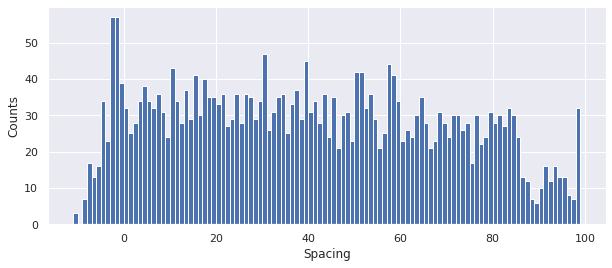

In [217]:
plt.hist(([x[0] for x in subset_p8]), bins=max(subset_p8)[0] - min(subset_p8)[0])
plt.xlabel("Spacing")
plt.ylabel("Counts")
plt.show()

In [218]:
([x for x in subset_p13 if x[0] == 22])[:2]

[(22,
  ('+', '+'),
  5.356586274672012,
  'chr17',
  Interval(39820417, 39820431, '+'),
  Interval(39820453, 39820467, '+')),
 (22,
  ('+', '+'),
  3.6888794541139363,
  'chr6',
  Interval(69220436, 69220450, '-'),
  Interval(69220400, 69220414, '-'))]

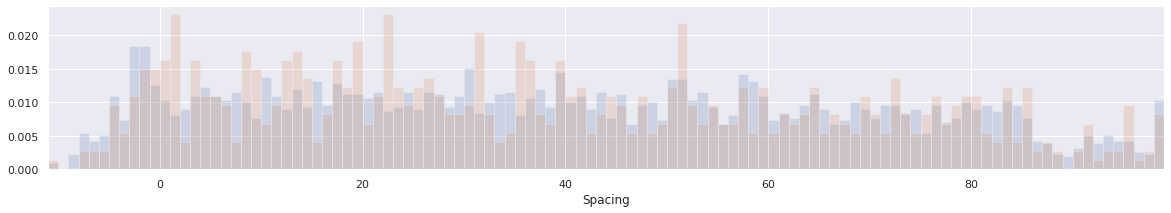

In [220]:
sns.set(rc={'figure.figsize':(20,3)})

# plt.hist(([x[0] for x in subset_p10]), bins=max(subset_p10)[0] - min(subset_p10)[0], alpha=0.2, density=True)
plt.hist(([x[0] for x in subset_p8]), bins=max(subset_p8)[0] - min(subset_p8)[0],alpha=0.2, density=True)
plt.hist(([x[0] for x in subset_p13]), bins=max(subset_p13)[0] - min(subset_p13)[0], alpha=0.2, density=True)
# plt.hist(([x[0] for x in subset_p11]), bins=max(subset_p11)[0] - min(subset_p11)[0], alpha=0.2, density=True)
plt.xlim(-11,99)
plt.xlabel("Spacing")
plt.show()

In [189]:
# make sure this holds true
min([x[0] for x in subset_p8]) == min([x[0] for x in subset_p10])  == min([x[0] for x in subset_p11]) ==min([x[0] for x in subset_p13]) 

True

In [224]:
freqs = []

for i,x in enumerate([subset_p8, subset_p10, subset_p11, subset_p13]):
    vals = [y[0] for y in x]
    cts = Counter(vals)
    freqs.append([])
    
    for y in range(min(cts.keys()), max(cts.keys())):
        freqs[-1].append(cts[y]/len(vals))

In [225]:
[len(x) for x in freqs]

[110, 110, 110, 110]

In [226]:
np.digitize([0,1,3,4,5,6,7,8], bins=[3])

array([0, 0, 1, 1, 1, 1, 1, 1])

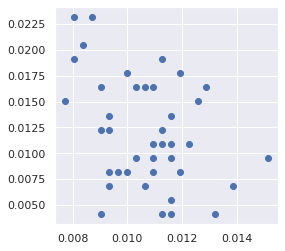

In [227]:
sns.set(rc={'figure.figsize':(4,4)})
plt.scatter(freqs[0][10:50], freqs[3][10:50])

In [228]:
print(pearsonr(freqs[0][13:53], freqs[3][13:53]))
print(spearmanr(freqs[0][13:53], freqs[3][13:53])[:])

(-0.26565335829955816, 0.09756349097322094)
(-0.25481039998072413, 0.11256285357831632)


In [229]:
from random import shuffle
from copy import deepcopy

In [230]:
pearsons = []
p8_cts = Counter([x[0] for x in subset_p8])
p13_cts = Counter([x[0] for x in subset_p13])

subset_cts_p8 = []
subset_cts_p13 = []

for i in range(2,42):
    subset_cts_p8.append(p8_cts[i])
    subset_cts_p13.append(p13_cts[i])

cur_subset_cts_p13 = deepcopy(subset_cts_p13)
# simulate null for pearson/spearman
for _ in range(1000):
    shuffle(cur_subset_cts_p13)
        
    pearsons.append([])
    for i in range(10,42):
        pearsons[-1].append(pearsonr(subset_cts_p8[:i], cur_subset_cts_p13[:i])[0])

In [231]:
observed_pearsons = []
for i in range(10,42):
    observed_pearsons.append(pearsonr(freqs[0][13:13+i], freqs[3][13:13+i])[0])

Text(0, 0.5, 'Correlation')

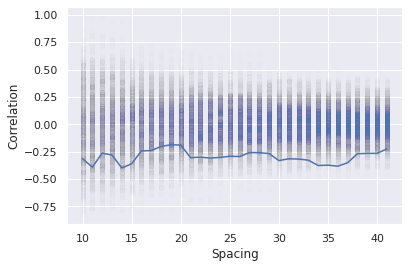

In [232]:
sns.set(rc={'figure.figsize':(6,4)})

plt.scatter(list(range(10,42))*1000, sum(pearsons, []), alpha=0.005, s=25)
plt.plot(range(10,42), observed_pearsons)
plt.xlabel("Spacing")
plt.ylabel("Correlation")

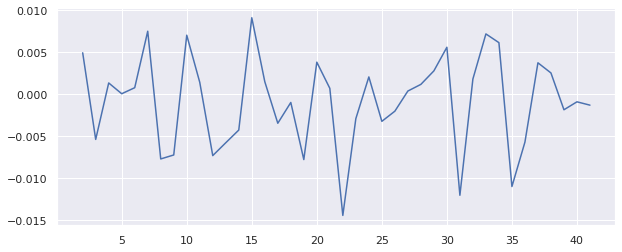

In [233]:
sns.set(rc={'figure.figsize':(10,4)})

plt.plot(range(2,42), [(p8_cts[i])/sum(p8_cts.values()) - (p13_cts[i])/sum(p13_cts.values()) for i in range(2,42)])

In [200]:
sorted(pearsons[0])[:10]

[-0.37147113995873704,
 -0.37103022824769905,
 -0.35414429035545364,
 -0.340477820825628,
 -0.3249872866418926,
 -0.3211127336499282,
 -0.31400082776073024,
 -0.3114687229623084,
 -0.3114060153205228,
 -0.3054556150700497]

In [201]:
sorted(pearsons)[500]

[-0.007996674075233252,
 0.042139474089893374,
 0.035479932707937485,
 -0.03651741558714722,
 -0.24964887170174974,
 -0.2162208792873093,
 -0.1760739267296577,
 -0.1896418624977426,
 -0.14089841703100248,
 -0.13484364017778963,
 -0.2010724192387898,
 -0.1846337054580418,
 -0.19424719866228232,
 -0.13558253441913792,
 -0.12804591597764536,
 -0.127190075171435,
 -0.1300903117406352,
 -0.1348001989811154,
 -0.1285915709058142,
 -0.13578389702164567,
 -0.13270430499078578,
 -0.12842390626336636,
 -0.13112441053490376,
 -0.1249833843867957,
 -0.11420474212809836,
 -0.14351737693598127,
 -0.14144148931775322,
 -0.13822733725341782,
 -0.13856860159817028,
 -0.13650665660740188,
 -0.13705086287671506,
 -0.13705086287671506]

In [202]:
sorted(pearsons)[3000]

IndexError: list index out of range

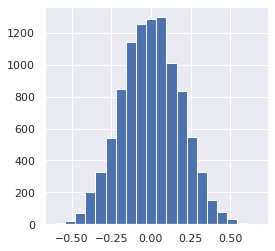

In [72]:
plt.hist(pearsons, bins=20)
plt.show()

In [44]:
max([x[0] for x in subset_p13])

99

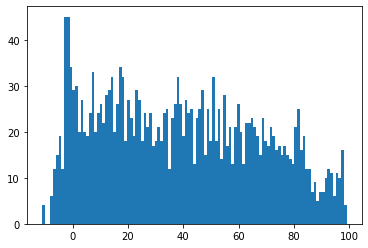

In [61]:
plt.hist(([x[0] for x in subset_p11 if x[1]==("+","+")]), bins=max(subset_p10)[0] - min(subset_p10)[0])
plt.show()

(array([0.00635571, 0.01108709, 0.01113925, 0.01087101, 0.01009611,
        0.0096416 , 0.01001415, 0.00874748, 0.00796512, 0.00417256]),
 array([-12. ,  -0.9,  10.2,  21.3,  32.4,  43.5,  54.6,  65.7,  76.8,
         87.9,  99. ]),
 <BarContainer object of 10 artists>)

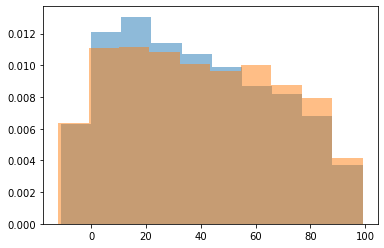

In [329]:
plt.hist(([x[0] for x in subset_p13]), density=True, alpha=0.5)
plt.hist(([x[0] for x in subset_p8]), density=True, alpha=0.5)

In [330]:
np.median([x[0] for x in subset_p13])

35.0

In [331]:
np.median([x[0] for x in subset_p11])

38.0

In [332]:
np.median([x[0] for x in subset_p10])

38.0

In [333]:
np.median([x[0] for x in subset_p8])

38.0

In [334]:
import scipy

In [361]:
print(scipy.stats.mannwhitneyu([x[0] for x in subset_p13], 
                               [x[0] for x in subset_p8])[1])

8.37716896726629e-05


In [336]:
sample(subset_p8, 5)

[(6,
  ('+', '-'),
  4.912654885736052,
  'chr8',
  Interval(115769769, 115769783, '-'),
  Interval(115769749, 115769763, '+')),
 (24,
  ('+', '+'),
  3.6109179126442243,
  'chr1',
  Interval(42272025, 42272039, '+'),
  Interval(42272063, 42272077, '+')),
 (86,
  ('-', '+'),
  4.442651256490317,
  'chr14',
  Interval(59176841, 59176855, '+'),
  Interval(59176741, 59176755, '-')),
 (42,
  ('-', '-'),
  4.77912349311153,
  'chr16',
  Interval(83297270, 83297284, '+'),
  Interval(83297214, 83297228, '+')),
 (1,
  ('-', '+'),
  4.477336814478207,
  'chr1',
  Interval(99841267, 99841281, '-'),
  Interval(99841282, 99841296, '+'))]